# LibriCrowd Analysis

In [1]:
import jiwer
import pandas as pd

In [2]:
# dataset_name = 'train_other_60h'
# df = pd.read_csv('./data/LibriSpeechCrowd/librispeech_{:s}_crowd.csv'.format(dataset_name), keep_default_na=False)
# df['std_trans_synthetic'] = df['std_trans_synthetic'].apply(lambda x: x.lower())
# d_rename = {'utt':'utt_id', 'gold_trans':'trans_ground_truth'}
# for col in df.columns:
#     if 'std_trans' in col:
#         d_rename[col] = col.replace('std_trans','trans_human')
# df.rename(columns = d_rename, inplace=True)
# df.info()
# df.to_csv('./data/LibriCrowd/{:s}_processed.csv'.format(dataset_name.replace('_','-')), index=False)

In [3]:
dataset_name = 'train_other_60h'
df = pd.read_csv('./data/LibriSpeechCrowd/librispeech_{:s}_crowd_1.csv'.format(dataset_name), keep_default_na=False)
d_rename = {'utt':'utt_id', 'gold_trans':'trans_ground_truth'}
for col in df.columns:
    if 'std_trans' in col:
        d_rename[col] = col.replace('std_trans','trans_human')
df.rename(columns = d_rename, inplace=True)
df.info()
df.to_csv('./data/raw/{:s}_raw.csv'.format(dataset_name.replace('_','-')), index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20187 entries, 0 to 20186
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   utt_id              20187 non-null  object 
 1   taskId              20187 non-null  object 
 2   trans_ground_truth  20187 non-null  object 
 3   trans_human         20187 non-null  object 
 4   approve_rate        20187 non-null  float64
 5   relabel             20187 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 946.4+ KB


### Check

In [4]:
def compute_metrics(gold_trans, std_trans):
    metrics = jiwer.compute_measures(gold_trans, std_trans)
    return metrics

In [5]:
def error_type(df, gold_trans='gold_trans', std_trans='std_trans'):
    df[std_trans] = df[std_trans].fillna('')
    df['std_trans_metrics'] = df.apply(lambda x: compute_metrics(x[gold_trans], x[std_trans]), axis=1)
    df['gold_trans_stc'] = df[gold_trans].apply(lambda x: len(x.split()))
    df['std_trans_stc'] = df[std_trans].apply(lambda x: len(x.split()))
    df['std_trans_del'] = df['std_trans_metrics'].apply(lambda x: x['deletions'])
    df['std_trans_ins'] = df['std_trans_metrics'].apply(lambda x: x['insertions'])
    df['std_trans_sub'] = df['std_trans_metrics'].apply(lambda x: x['substitutions'])
    df['std_trans_wec'] = df['std_trans_metrics'].apply(lambda x: x['deletions'] + x['insertions'] + x['substitutions'])
    res = dict()
    res['CNT'] = len(df)
    res['LEN'] = df['std_trans_stc'].sum() / len(df)
    res['DEL'] = df['std_trans_del'].sum() / df['gold_trans_stc'].sum() * 100
    res['INS'] = df['std_trans_ins'].sum() / df['gold_trans_stc'].sum() * 100
    res['SUB'] = df['std_trans_sub'].sum() / df['gold_trans_stc'].sum() * 100
    res['WER'] = df['std_trans_wec'].sum() / df['gold_trans_stc'].sum() * 100
    return res

In [6]:
dataset = 'test-other'

In [7]:
df_check = pd.read_csv('./data/raw/{:s}_raw.csv'.format(dataset))
df_check['trans_ground_truth'][df_check['trans_ground_truth']==' '] = 'ImputedNA'
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29333 entries, 0 to 29332
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   utt_id              29333 non-null  object 
 1   taskId              29333 non-null  object 
 2   trans_ground_truth  29333 non-null  object 
 3   trans_human_crowd   29298 non-null  object 
 4   approve_rate        29333 non-null  float64
 5   relabel             29333 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.3+ MB


/var/folders/b3/d7n5t47x4nl6wt3lhs2_stn1cdmymq/T/ipykernel_70014/3634011164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check['trans_ground_truth'][df_check['trans_ground_truth']==' '] = 'ImputedNA'


In [8]:
res = error_type(df_check, gold_trans='trans_ground_truth', std_trans='trans_human_crowd')
print('dataset = {:s}, col = {:s}: count = {:d}, len = {:.1f}, del = {:.2f}%, ins = {:5.2f}%, sub = {:5.2f}%, wer = {:5.2f}%'\
      .format(dataset, col, res['CNT'], res['LEN'], res['DEL'], res['INS'], res['SUB'], res['WER']))

dataset = test-other, col = relabel: count = 29333, len = 17.3, del = 4.54%, ins =  1.39%, sub =  8.59%, wer = 14.52%


### Plot

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)

In [10]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# y1 = [0, 1.18, 2, 4.32, 6.4, 7.98, 8.37, 10.61, 11.78, 12.91, 14.37] # werr_wo_lm
# y2  = [0, 4.22, 4.94, 6.31, 7.42, 10.27, 12.56, 14.47, 15.37, 14.47, 18.27] # werr_w_lm
y1 = [0, 2.68, 3.3, 5.87, 7.97, 8.20, 8.37, 12.24, 13.44, 14.58, 16.06] # werr_wo_lm
y2  = [0, 4.22, 5.53, 7.40, 8.53, 9.09, 12.56, 15.65, 15.37, 15.65, 19.49] # werr_w_lm

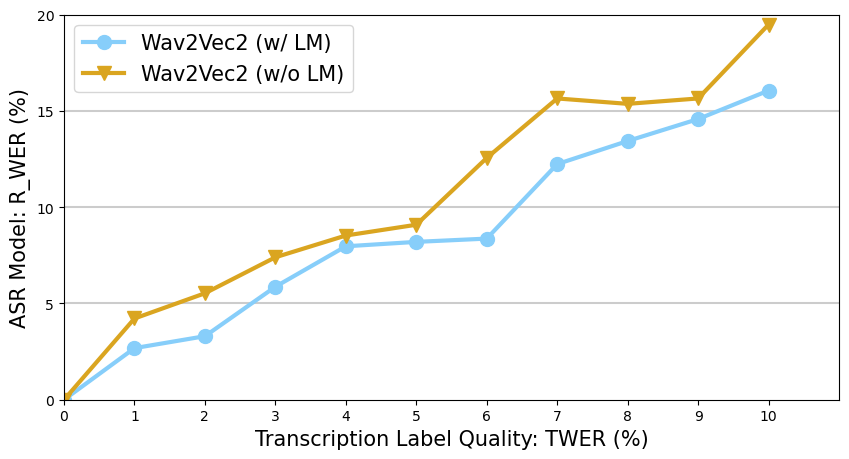

In [11]:
plt.axhline(y=5, color=(0, 0, 0, 0.2), linestyle='-')
plt.axhline(y=10, color=(0, 0, 0, 0.2), linestyle='-')
plt.axhline(y=15, color=(0, 0, 0, 0.2), linestyle='-')
# plt.axhline(y=10, color=(0, 0, 0, 0.2), linestyle='-')
plt.plot(x, y1, linestyle='-', marker='o', color='LightSkyBlue', label='Wav2Vec2 (w/ LM)', linewidth=3.0, markersize=10)
plt.plot(x, y2, linestyle='-', marker='v', color='GoldEnrod', label='Wav2Vec2 (w/o LM)', linewidth=3.0, markersize=10)
plt.axis([0, 11, 0, 20])
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.yticks(np.arange(min(y2), max(y2)+2, 5.0))
plt.xlabel('Transcription Label Quality: TWER (%)', fontsize=15)
plt.ylabel('ASR Model: R_WER (%)', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

In [12]:
x  = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80]
y1 = [9.87, 8.45, 7.81, 7.69, 7.4, 7.30, 7.2, 7.140, 7.11, 7.0, 6.96] # TWER = 5%
y2 = [9.52, 7.79, 7.09, 6.73, 6.0, 5.60, 5.39, 5.3, 5.29, 5.2, 5.11] # TWER = 0%

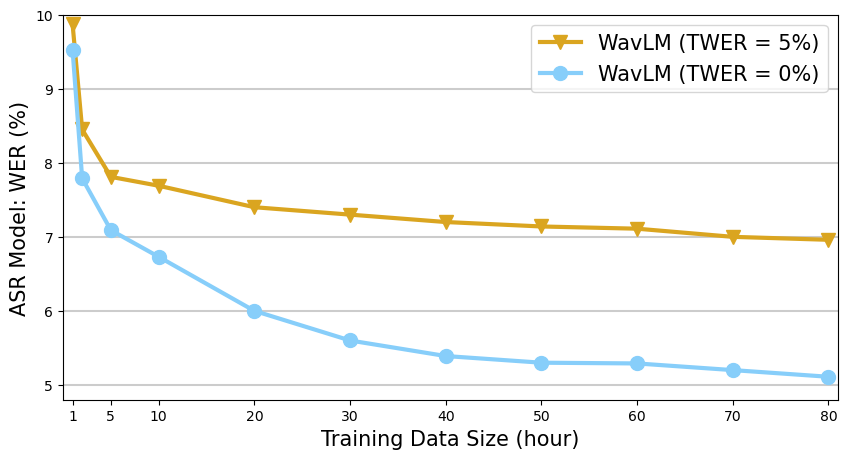

In [13]:
plt.axhline(y=5, color=(0, 0, 0, 0.2), linestyle='-')
plt.axhline(y=6, color=(0, 0, 0, 0.2), linestyle='-')
plt.axhline(y=7, color=(0, 0, 0, 0.2), linestyle='-')
plt.axhline(y=8, color=(0, 0, 0, 0.2), linestyle='-')
plt.axhline(y=9, color=(0, 0, 0, 0.2), linestyle='-')
plt.plot(x, y1, linestyle='-', marker='v', color='GoldEnrod', label='WavLM (TWER = 5%)', linewidth=3.0, markersize=10)
plt.plot(x, y2, linestyle='-', marker='o', color='LightSkyBlue', label='WavLM (TWER = 0%)', linewidth=3.0, markersize=10)
plt.axis([0, 81, 4.8, 10])
plt.xticks([1, 5, 10, 20, 30, 40, 50, 60, 70, 80])
plt.yticks([5, 6, 7, 8, 9, 10])
plt.xlabel('Training Data Size (hour)', fontsize=15)
plt.ylabel('ASR Model: WER (%)', fontsize=15)
plt.legend(fontsize=15, loc='upper right')
plt.show()